In [ ]:
# Mount once at the beginning
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import zipfile, os
zip_path = '/content/drive/MyDrive/BUSI_Datasett.zip'
extract_path = '/content/BUSI_Dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted to", extract_path)


✅ Dataset extracted to /content/BUSI_Dataset


In [ ]:
!pip install opencv-python-headless seaborn


In [ ]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50


In [ ]:
def load_data(dataset_path, img_size=(128,128)):
    X, Y_mask, Y_label = [], [], []
    for label_name, label_idx in zip(['normal','benign','malignant'],[0,1,2]):
        folder = os.path.join(dataset_path,label_name)
        files = os.listdir(folder)
        image_files = sorted([f for f in files if 'mask' not in f])
        for image_file in image_files:
            mask_file = image_file.replace('.png','_mask.png')
            img = cv2.imread(os.path.join(folder,image_file),cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(folder,mask_file),cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None: continue
            img = cv2.resize(img,img_size)/255.0
            mask = cv2.resize(mask,img_size)/255.0
            X.append(img); Y_mask.append(mask); Y_label.append(label_idx)
    return np.expand_dims(np.array(X),-1),np.expand_dims(np.array(Y_mask),-1),np.array(Y_label)

X,Y_mask,Y_label = load_data("/content/BUSI_Dataset/Dataset_BUSI_with_GT")
print(f"Images:{X.shape}, Masks:{Y_mask.shape}, Labels:{Y_label.shape}")


Images:(780, 128, 128, 1), Masks:(780, 128, 128, 1), Labels:(780,)


In [ ]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(Y_label), y=Y_label)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.9548872180451127), 1: np.float64(0.5949656750572082), 2: np.float64(1.2380952380952381)}


In [ ]:
X_train,X_test,Y_mask_train,Y_mask_test,Y_label_train,Y_label_test = train_test_split(
    X,Y_mask,Y_label,test_size=0.2,stratify=Y_label,random_state=42)
Y_label_train_cat = to_categorical(Y_label_train,3)
Y_label_test_cat = to_categorical(Y_label_test,3)


In [ ]:
image_datagen = ImageDataGenerator(
    rotation_range=30,width_shift_range=0.1,height_shift_range=0.1,
    shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
mask_datagen = ImageDataGenerator(
    rotation_range=30,width_shift_range=0.1,height_shift_range=0.1,
    shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')


In [ ]:
def dice_loss(y_true,y_pred,smooth=1e-6):
    y_true_f,y_pred_f = tf.keras.backend.flatten(y_true),tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f*y_pred_f)
    return 1 - (2.*intersection + smooth)/(tf.keras.backend.sum(y_true_f)+tf.keras.backend.sum(y_pred_f)+smooth)

def focal_loss(y_true,y_pred,gamma=2.0,alpha=0.25):
    y_true = tf.cast(y_true,tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true,y_pred)
    bce_exp = tf.exp(-bce)
    return tf.reduce_mean(alpha*tf.pow((1-bce_exp),gamma)*bce)

def combined_loss(y_true,y_pred):
    return 0.5*dice_loss(y_true,y_pred) + 0.5*focal_loss(y_true,y_pred)


In [ ]:
def squeeze_excite_block(input_tensor,ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters//ratio,activation='relu')(se)
    se = layers.Dense(filters,activation='sigmoid')(se)
    return layers.Multiply()([input_tensor,se])


In [ ]:
def build_sunet(input_shape=(128,128,1)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(32,3,activation='relu',padding='same')(inputs)
    c1 = layers.Conv2D(32,3,activation='relu',padding='same')(c1)
    c1 = squeeze_excite_block(c1); p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(64,3,activation='relu',padding='same',dilation_rate=2)(p1)
    c2 = layers.Conv2D(64,3,activation='relu',padding='same')(c2)
    c2 = squeeze_excite_block(c2); p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(128,3,activation='relu',padding='same',dilation_rate=4)(p2)
    c3 = layers.Conv2D(128,3,activation='relu',padding='same')(c3)
    c3 = squeeze_excite_block(c3)
    u1 = layers.UpSampling2D()(c3); m1 = layers.concatenate([u1,c2])
    c4 = layers.Conv2D(64,3,activation='relu',padding='same')(m1); c4 = squeeze_excite_block(c4)
    u2 = layers.UpSampling2D()(c4); m2 = layers.concatenate([u2,c1])
    c5 = layers.Conv2D(32,3,activation='relu',padding='same')(m2); c5 = squeeze_excite_block(c5)
    outputs = layers.Conv2D(1,1,activation='sigmoid')(c5)
    return models.Model(inputs,outputs)

unet = build_sunet()
unet.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=combined_loss,metrics=['accuracy'])
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        132 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        576 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│ (Multiply)          │ 64)               │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ multiply_1[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 431,817 (1.65 MB)

 Trainable params: 431,817 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
seed = 42
image_generator = image_datagen.flow(X_train,seed=seed,batch_size=16)
mask_generator = mask_datagen.flow(Y_mask_train,seed=seed,batch_size=16)
def generator():
    while True:
        x = next(image_generator); y = next(mask_generator); yield x,y
train_dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1),dtype=tf.float32),
        tf.TensorSpec(shape=(None,128,128,1),dtype=tf.float32)
    )
)


In [ ]:
unet.fit(train_dataset,steps_per_epoch=len(X_train)//16,epochs=50)
predicted_masks = unet.predict(X)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9579 - loss: 0.1625
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9572 - loss: 0.1711
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9539 - loss: 0.1671
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9579 - loss: 0.1642
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9558 - loss: 0.1551
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9584 - loss: 0.1586
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9594 - loss: 0.1393
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9504 - loss: 0.1709
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9564 - loss: 0.1706
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9501 - loss: 0.1725
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9535 - loss: 0.1805
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy:

In [ ]:
y_true_flat = (Y_mask>0.5).astype(np.uint8).reshape(-1)
y_pred_flat = (predicted_masks>0.5).astype(np.uint8).reshape(-1)
iou = jaccard_score(y_true_flat,y_pred_flat,average='binary')
print(f"Segmentation IoU: {iou:.4f}")

Segmentation IoU: 0.6587


In [ ]:
def dice_coefficient(y_true,y_pred):
    y_true_f=(y_true>0.5).astype(np.uint8).flatten()
    y_pred_f=(y_pred>0.5).astype(np.uint8).flatten()
    intersection=np.sum(y_true_f*y_pred_f)
    return (2.*intersection)/(np.sum(y_true_f)+np.sum(y_pred_f))
dice = dice_coefficient(Y_mask,predicted_masks)
print(f"Dice Coefficient: {dice:.4f}")

Dice Coefficient: 0.7942


In [ ]:
from sklearn.metrics import accuracy_score

# Flatten predictions and true masks
y_pred_flat = (predicted_masks > 0.5).astype(np.uint8).flatten()
y_true_flat = (Y_mask > 0.5).astype(np.uint8).flatten()

# Compute pixel-wise accuracy
final_accuracy = accuracy_score(y_true_flat, y_pred_flat)

# Output result
print(f"✅ Final Pixel-wise Segmentation Accuracy (Model 1 – SUNet): {final_accuracy:.4f}")


✅ Final Pixel-wise Segmentation Accuracy (Model 1 – SUNet): 0.9686


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Flatten predicted and true masks to 1D binary arrays
y_pred_flat = (predicted_masks > 0.5).astype(np.uint8).flatten()
y_true_flat = (Y_mask > 0.5).astype(np.uint8).flatten()

# Generate the classification report
report = classification_report(
    y_true_flat,
    y_pred_flat,
    target_names=["Background", "Lesion"],
    output_dict=True  # to extract accuracy
)

# Print report text
print("📋 Pixel-wise Classification Report (Model 1 – Segmentation):")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    target_names=["Background", "Lesion"]
))

# Print accuracy separately
accuracy = report["accuracy"]
print(f"✅ Pixel-wise Accuracy (Model 1): {accuracy:.4f}")


📋 Pixel-wise Classification Report (Model 1 – Segmentation):
              precision    recall  f1-score   support

  Background       0.98      0.98      0.98  11793443
      Lesion       0.80      0.79      0.79    986077

    accuracy                           0.97  12779520
   macro avg       0.89      0.88      0.89  12779520
weighted avg       0.97      0.97      0.97  12779520

✅ Pixel-wise Accuracy (Model 1): 0.9686


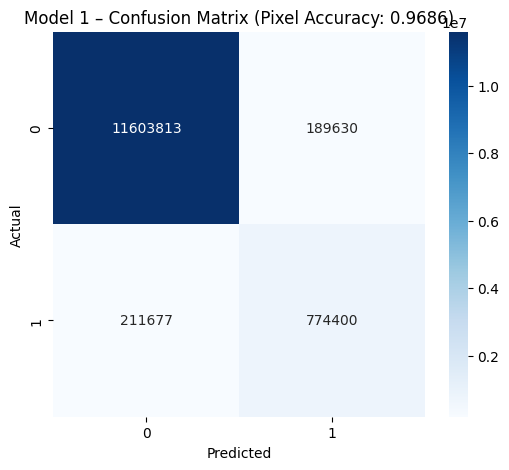

In [ ]:
# 🧩 Model 1 – Confusion Matrix (with Accuracy in Title)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Convert masks to binary class labels for evaluation
y_true_flat = (Y_mask > 0.5).astype(np.uint8).reshape(-1)
y_pred_flat = (predicted_masks > 0.5).astype(np.uint8).reshape(-1)

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
acc = accuracy_score(y_true_flat, y_pred_flat)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Model 1 – Confusion Matrix (Pixel Accuracy: {acc:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


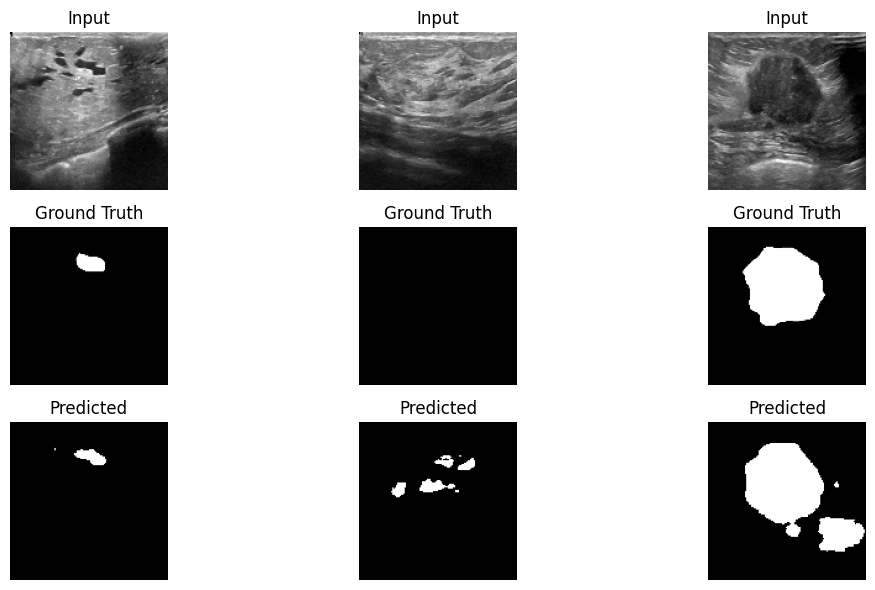

In [ ]:
import matplotlib.pyplot as plt

# Predict with Model 1
pred_model1 = unet.predict(X_test)

# Plot a few predictions
num_samples = 3
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis("off")

    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow(Y_mask_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, num_samples, i + 1 + 2*num_samples)
    plt.imshow((pred_model1[i].squeeze() > 0.5), cmap='gray')
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
unet.save("/content/drive/MyDrive/unet_model1.keras")
print("✅ Model 1 saved as unet_model1.keras")


✅ Model 1 saved as unet_model1.keras


In [ ]:
# 🧩 Model 2: Setup
# Install segmentation-models (includes U-Net++, DeepLabV3+, FPN, etc.)
!pip install -U segmentation-models --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
# 🧩 Model 2: U-Net++ – Building Blocks
from tensorflow.keras import layers, models

def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def upsample_concat_block(x, xskip):
    u = layers.UpSampling2D((2,2))(x)
    return layers.Concatenate()([u, xskip])


In [ ]:
# 🧩 Model 2: U-Net++ – Model Definition
def build_unetpp(input_shape=(128,128,1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder with nested skip connections
    u6 = upsample_concat_block(c5, c4)
    c6 = conv_block(u6, 256)

    u7 = upsample_concat_block(c6, c3)
    c7 = conv_block(u7, 128)

    u8 = upsample_concat_block(c7, c2)
    c8 = conv_block(u8, 64)

    u9 = upsample_concat_block(c8, c1)
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(c9)

    return models.Model(inputs, outputs)

# Instantiate and compile the model
unetpp = build_unetpp()
unetpp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unetpp.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_4[

 Total params: 7,857,857 (29.98 MB)

 Trainable params: 7,851,969 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# 🧩 Model 2: U-Net++ – Training
history_unetpp = unetpp.fit(
    X_train, Y_mask_train,
    validation_data=(X_test, Y_mask_test),
    epochs=50,
    batch_size=16
)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9510 - loss: 0.1374 - val_accuracy: 0.9057 - val_loss: 8.4762
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9650 - loss: 0.0903 - val_accuracy: 0.9440 - val_loss: 0.4345
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9751 - loss: 0.0617 - val_accuracy: 0.9538 - val_loss: 0.1648
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9838 - loss: 0.0404 - val_accuracy: 0.9538 - val_loss: 0.1570
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9843 - loss: 0.0385 - val_accuracy: 0.9573 - val_loss: 0.1377
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9872 - loss: 0.0301 - val_accuracy: 0.9629 - val_loss: 0.1273
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9888 - loss: 0.0257 - val_accuracy: 0.9618 - val_loss: 0.1203
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9905 - loss: 0.0217 - val_accuracy: 0.9610

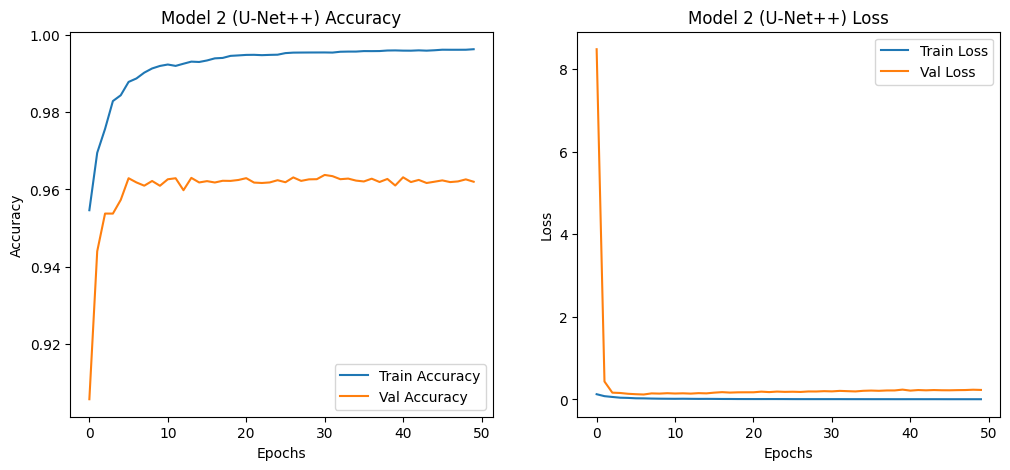

In [ ]:
# =======================
# 📈 Training Curves for Model 2 (U-Net++)
# =======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_unetpp.history['accuracy'], label='Train Accuracy')
plt.plot(history_unetpp.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 2 (U-Net++) Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_unetpp.history['loss'], label='Train Loss')
plt.plot(history_unetpp.history['val_loss'], label='Val Loss')
plt.title('Model 2 (U-Net++) Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# 🧩 Predict masks on full data
pred_unetpp = unetpp.predict(X, verbose=1)

# 🧩 Flatten predictions and true masks
y_pred_flat = (pred_unetpp > 0.5).astype(np.uint8).flatten()
y_true_flat = (Y_mask > 0.5).astype(np.uint8).flatten()

# 🧩 Compute pixel-wise accuracy
final_accuracy_unetpp = accuracy_score(y_true_flat, y_pred_flat)

# 🧩 Print result
print(f"✅ Final Pixel-wise Accuracy (Model 2 – U-Net++): {final_accuracy_unetpp:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
✅ Final Pixel-wise Accuracy (Model 2 – U-Net++): 0.9907


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# 🧩 Model 2: U-Net++ – Classification Report (Full Dataset)

# Flatten predicted and true masks
y_pred_flat = (pred_unetpp > 0.5).astype(np.uint8).flatten()
y_true_flat = (Y_mask > 0.5).astype(np.uint8).flatten()

# Generate report dictionary to extract accuracy
report_dict = classification_report(
    y_true_flat,
    y_pred_flat,
    target_names=["Background", "Lesion"],
    output_dict=True
)

# Print full classification report
print("📋 Pixel-wise Classification Report (Model 2 – U-Net++):")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    target_names=["Background", "Lesion"]
))

# Print pixel-wise accuracy explicitly
accuracy = report_dict["accuracy"]
print(f"✅ Final Pixel-wise Accuracy (Model 2 – U-Net++): {accuracy:.4f}")


📋 Pixel-wise Classification Report (Model 2 – U-Net++):
              precision    recall  f1-score   support

  Background       0.99      1.00      0.99  11793443
      Lesion       0.95      0.93      0.94    986077

    accuracy                           0.99  12779520
   macro avg       0.97      0.96      0.97  12779520
weighted avg       0.99      0.99      0.99  12779520

✅ Final Pixel-wise Accuracy (Model 2 – U-Net++): 0.9907


/tmp/ipython-input-42-2722531403.py:24: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


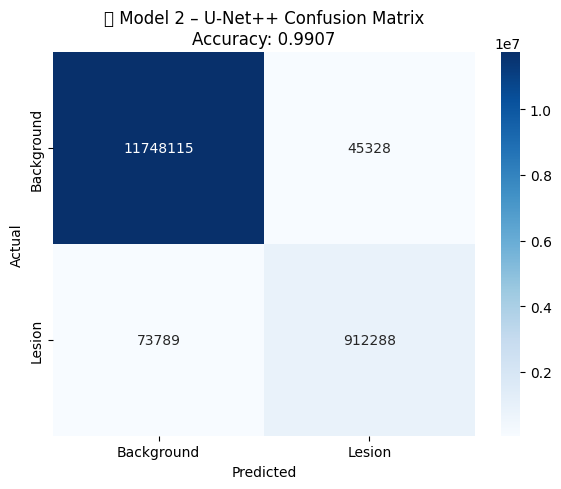

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 🧩 Model 2: Flatten masks
y_pred_flat = (pred_unetpp > 0.5).astype(np.uint8).flatten()
y_true_flat = (Y_mask > 0.5).astype(np.uint8).flatten()

# 🧩 Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# 🧩 Compute accuracy
acc = accuracy_score(y_true_flat, y_pred_flat)

# 🧩 Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Background", "Lesion"],
            yticklabels=["Background", "Lesion"])

plt.title(f"🧩 Model 2 – U-Net++ Confusion Matrix\nAccuracy: {acc:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
unetpp.save("/content/drive/MyDrive/unetpp_model2.keras")
print("✅ Model 2 saved as unetpp_model2.keras")


✅ Model 2 saved as unetpp_model2.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc


In [ ]:
from tensorflow.keras.models import load_model

# Load Model 1 (U-Net)
unet = load_model("/content/drive/MyDrive/unet_model1.keras", custom_objects={'combined_loss': combined_loss})
print("✅ Model 1 loaded successfully!")


✅ Model 1 loaded successfully!


In [ ]:
unetpp = load_model("/content/drive/MyDrive/unetpp_model2.keras")
print("✅ Model 2 loaded successfully!")


✅ Model 2 loaded successfully!


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step


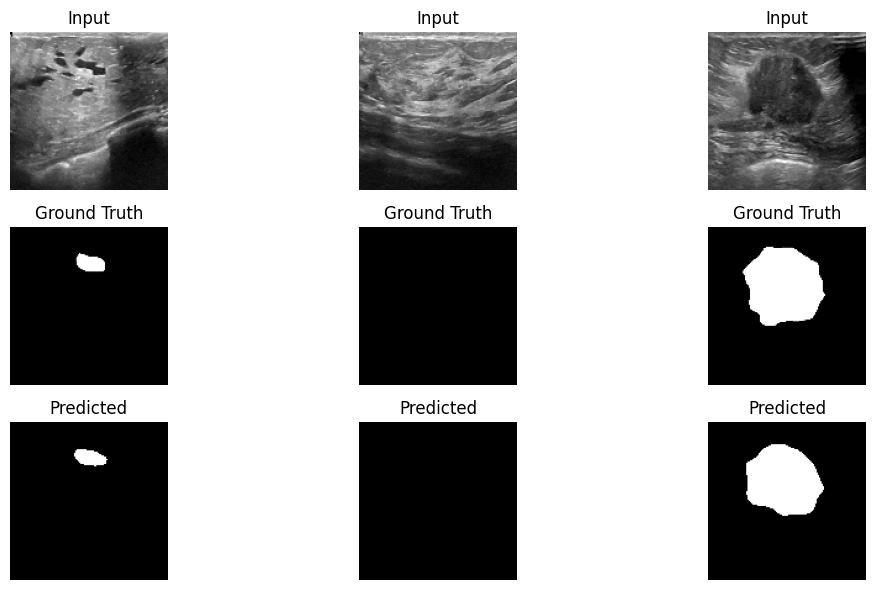

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 🧩 Predict with Model 2
pred_model2 = unetpp.predict(X_test)

# 🧩 Visualize predictions
num_samples = 3  # Change this to view more samples
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    # Input image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow(Y_mask_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted mask (binarized)
    plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
    plt.imshow((pred_model2[i].squeeze() > 0.5), cmap='gray')
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()


Using Grad-CAM on layer: conv2d_27


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


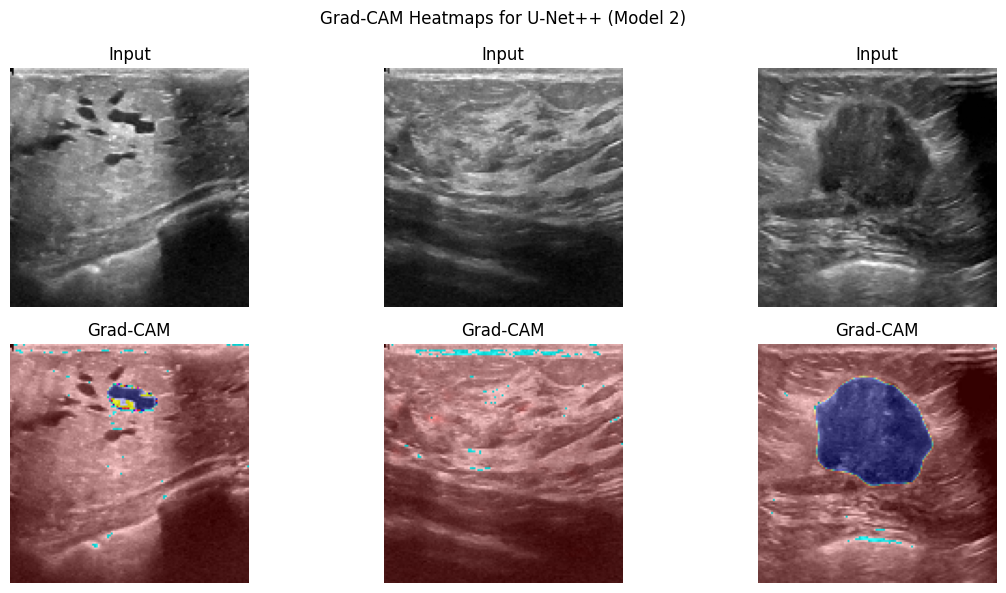

In [ ]:
# =======================
# 🔥 Grad-CAM Heatmaps for Model 2 (U-Net++)
# =======================
import tensorflow as tf
import cv2

def grad_cam(model, image, layer_name):
    """Generate Grad-CAM heatmap for a single grayscale image."""
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = tf.reduce_mean(predictions)  # Average over output
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()

# Choose a convolution layer near the end of U-Net++
last_conv_layer = [layer.name for layer in unetpp.layers if 'conv2d' in layer.name][-1]
print(f"Using Grad-CAM on layer: {last_conv_layer}")

# Pick some test samples
sample_indices = [0, 1, 2]
plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    heatmap = grad_cam(unetpp, img, last_conv_layer)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Plot original & Grad-CAM
    plt.subplot(2, len(sample_indices), i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Input"); plt.axis("off")

    plt.subplot(2, len(sample_indices), i+1+len(sample_indices))
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title("Grad-CAM"); plt.axis("off")

plt.suptitle("Grad-CAM Heatmaps for U-Net++ (Model 2)")
plt.tight_layout()
plt.show()


Epoch 1/100
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3614 - loss: 1.4833
Epoch 1: val_accuracy improved from -inf to 0.55769, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.3645 - loss: 1.4764 - val_accuracy: 0.5577 - val_loss: 1.0515 - learning_rate: 5.0000e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4634 - loss: 1.1269
Epoch 2: val_accuracy did not improve from 0.55769
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4638 - loss: 1.1275 - val_accuracy: 0.1923 - val_loss: 2.0805 - learning_rate: 5.0000e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5158 - loss: 1.0099
Epoch 3: val_accuracy did not improve from 0.55769
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5167 - loss: 1.0094 - val_accuracy: 0.4359 - val_loss: 1.6099 - learning_rate: 5.0000e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5712 - loss: 0.9297
Epoch 4: val_accuracy did not improve from 0.55769
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5713 - loss: 0.9301 - val_accuracy: 0.1731 - val_loss: 3.9123 - learning_rate: 5.0000e-04
Epoch 5/100


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9288 - loss: 0.1483 - val_accuracy: 0.5769 - val_loss: 1.3748 - learning_rate: 1.2500e-04
Epoch 15/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9703 - loss: 0.1054
Epoch 15: val_accuracy improved from 0.57692 to 0.73718, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9703 - loss: 0.1052 - val_accuracy: 0.7372 - val_loss: 0.6074 - learning_rate: 1.2500e-04
Epoch 16/100
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9629 - loss: 0.1140
Epoch 16: val_accuracy improved from 0.73718 to 0.77564, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9632 - loss: 0.1135 - val_accuracy: 0.7756 - val_loss: 0.5565 - learning_rate: 1.2500e-04
Epoch 17/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9787 - loss: 0.0830
Epoch 17: val_accuracy did not improve from 0.77564
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9786 - loss: 0.0831 - val_accuracy: 0.5385 - val_loss: 2.6336 - learning_rate: 1.2500e-04
Epoch 18/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9568 - loss: 0.0879
Epoch 18: val_accuracy did not improve from 0.77564
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9569 - loss: 0.0881 - val_accuracy: 0.6987 - val_loss: 0.8381 - learning_rate: 1.2500e-04
Epoch 19/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9802 - loss: 0.0847
Epoch 19: val_accuracy improved from 0.77564 to 0.80769, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9800 - loss: 0.0848 - val_accuracy: 0.8077 - val_loss: 0.4837 - learning_rate: 1.2500e-04
Epoch 20/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9818 - loss: 0.0555
Epoch 20: val_accuracy did not improve from 0.80769
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9819 - loss: 0.0554 - val_accuracy: 0.7821 - val_loss: 0.5872 - learning_rate: 1.2500e-04
Epoch 21/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9693 - loss: 0.0900
Epoch 21: val_accuracy improved from 0.80769 to 0.85256, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9692 - loss: 0.0901 - val_accuracy: 0.8526 - val_loss: 0.4015 - learning_rate: 1.2500e-04
Epoch 22/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9943 - loss: 0.0457
Epoch 22: val_accuracy improved from 0.85256 to 0.85897, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9942 - loss: 0.0459 - val_accuracy: 0.8590 - val_loss: 0.3747 - learning_rate: 1.2500e-04
Epoch 23/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9944 - loss: 0.0394
Epoch 23: val_accuracy did not improve from 0.85897
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9943 - loss: 0.0396 - val_accuracy: 0.7821 - val_loss: 0.6369 - learning_rate: 1.2500e-04
Epoch 24/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9826 - loss: 0.0578
Epoch 24: val_accuracy did not improve from 0.85897
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9826 - loss: 0.0578 - val_accuracy: 0.8590 - val_loss: 0.4091 - learning_rate: 1.2500e-04
Epoch 25/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9880 - loss: 0.0539
Epoch 25: val_accuracy did not improve from 0.85897
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9879 - loss: 0.0540 - val_accuracy: 0.8333 - val_loss: 0.4408 - learning_rate: 1.2500e-04
Epoch 2

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9718 - loss: 0.0808 - val_accuracy: 0.8654 - val_loss: 0.4796 - learning_rate: 1.2500e-04
Epoch 29/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9688 - loss: 0.0693
Epoch 29: val_accuracy did not improve from 0.86538
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9684 - loss: 0.0702 - val_accuracy: 0.7692 - val_loss: 0.7861 - learning_rate: 1.2500e-04
Epoch 30/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9683 - loss: 0.0712
Epoch 30: val_accuracy did not improve from 0.86538
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9684 - loss: 0.0709 - val_accuracy: 0.7051 - val_loss: 1.0307 - learning_rate: 1.2500e-04
Epoch 31/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9835 - loss: 0.0512
Epoch 31: val_accuracy did not improve from 0.86538
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9835 - loss: 0.0516 - val_accuracy: 0.8462 - val_loss: 0.4271 - learning_rate: 1.2500e-04
Epoch 3

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9931 - loss: 0.0174 - val_accuracy: 0.8782 - val_loss: 0.4006 - learning_rate: 3.1250e-05
Epoch 43/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9954 - loss: 0.0203
Epoch 43: val_accuracy improved from 0.87821 to 0.88462, saving model to best_unetpp_cls.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9953 - loss: 0.0203 - val_accuracy: 0.8846 - val_loss: 0.3990 - learning_rate: 3.1250e-05
Epoch 44/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9931 - loss: 0.0233
Epoch 44: val_accuracy did not improve from 0.88462
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9932 - loss: 0.0232 - val_accuracy: 0.8718 - val_loss: 0.4038 - learning_rate: 3.1250e-05
Epoch 45/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9924 - loss: 0.0205
Epoch 45: val_accuracy did not improve from 0.88462
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9923 - loss: 0.0207 - val_accuracy: 0.8590 - val_loss: 0.3775 - learning_rate: 3.1250e-05
Epoch 46/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0104
Epoch 46: val_accuracy did not improve from 0.88462
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.8782 - val_loss: 0.3603 - learning_rate: 3.1250e-05
Epoch 4

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9950 - loss: 0.0278 - val_accuracy: 0.9103 - val_loss: 0.3711 - learning_rate: 3.1250e-05
Epoch 48/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9846 - loss: 0.0238
Epoch 48: val_accuracy did not improve from 0.91026
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9848 - loss: 0.0237 - val_accuracy: 0.8462 - val_loss: 0.4938 - learning_rate: 3.1250e-05
Epoch 49/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9924 - loss: 0.0250
Epoch 49: val_accuracy did not improve from 0.91026
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9924 - loss: 0.0251 - val_accuracy: 0.8654 - val_loss: 0.3578 - learning_rate: 3.1250e-05
Epoch 50/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9952 - loss: 0.0133
Epoch 50: val_accuracy did not improve from 0.91026
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9952 - loss: 0.0134 - val_accuracy: 0.8846 - val_loss: 0.3592 - learning_rate: 3.1250e-05
Epoch 5

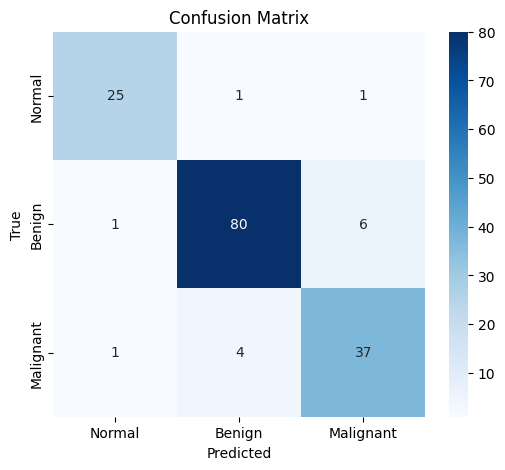

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 🧩 Same conv_block from Model 2 U-Net++
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    return x

# 🧠 U-Net++ Classifier Model
def build_unetpp_classifier(input_shape=(128,128,1), num_classes=3):
    inputs = layers.Input(input_shape)

    # Encoder from Model 2
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = conv_block(p4, 512)

    # Classification Head (Minor Dropout Changes)
    x = layers.GlobalAveragePooling2D()(c5)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # ↓ Reduced from 0.5 to retain more signal

    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # ↓ Reduced from 0.3 for less regularization

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# 🔧 Build & Compile
unetpp_classifier = build_unetpp_classifier()
unetpp_classifier.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4),  # 🔁 Slightly reduced LR for stable learning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 📉 Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, verbose=1, min_lr=1e-6)
model_ckpt = callbacks.ModelCheckpoint("best_unetpp_cls.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# 🏋️ Train
history = unetpp_classifier.fit(
    X_train, Y_label_train,
    validation_data=(X_test, Y_label_test),
    epochs=100,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)

# ✅ Evaluate
loss, acc = unetpp_classifier.evaluate(X_test, Y_label_test)
print(f"\n✅ Classification Accuracy: {acc*100:.2f}%")

# 🔍 Predictions
y_pred = np.argmax(unetpp_classifier.predict(X_test), axis=-1)

# 📋 Classification Report
print("\nClassification Report:")
print(classification_report(Y_label_test, y_pred, target_names=['Normal', 'Benign', 'Malignant']))

# 📊 Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(Y_label_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Benign','Malignant'],
            yticklabels=['Normal','Benign','Malignant'])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.6848 - loss: 0.6800 - val_accuracy: 0.1424 - val_loss: 9.5318
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9137 - loss: 0.4892 - val_accuracy: 0.6657 - val_loss: 0.6310
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9287 - loss: 0.3994 - val_accuracy: 0.1062 - val_loss: 126.5209
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9331 - loss: 0.3185 - val_accuracy: 0.5379 - val_loss: 2.9857
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9442 - loss: 0.2613 - val_accuracy: 0.1322 - val_loss: 27.7728
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9504 - loss: 0.2031 - val_accuracy: 0.8293 - val_loss: 0.4321
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9480 - loss: 0.1834 - val_accuracy: 0.5745 - val_loss: 0.6661
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9547 - loss: 0.1557 - val_accuracy: 0.91

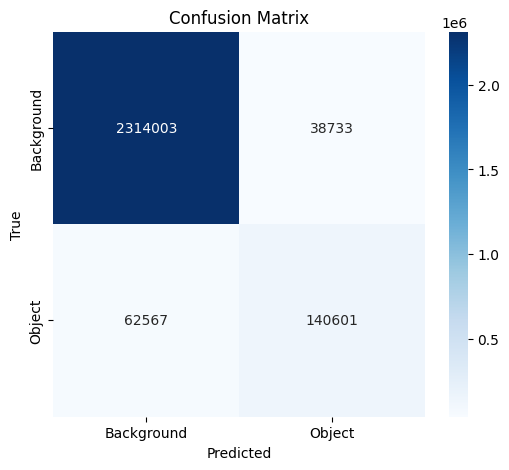

In [ ]:
# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Model definition
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def upsample_concat_block(x, xskip):
    u = layers.UpSampling2D((2,2))(x)
    return layers.Concatenate()([u, xskip])

def build_unetpp(input_shape=(128,128,1)):
    inputs = layers.Input(input_shape)

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = conv_block(p4, 512)

    u6 = upsample_concat_block(c5, c4)
    c6 = conv_block(u6, 256)

    u7 = upsample_concat_block(c6, c3)
    c7 = conv_block(u7, 128)

    u8 = upsample_concat_block(c7, c2)
    c8 = conv_block(u8, 64)

    u9 = upsample_concat_block(c8, c1)
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(c9)

    return models.Model(inputs, outputs)

# ✅ Prepare data (assuming X_train, Y_mask_train, X_test, Y_mask_test already exist)
# Normalize if not done
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
Y_mask_train = Y_mask_train.astype("float32")
Y_mask_test = Y_mask_test.astype("float32")

# ✅ tf.data.Dataset pipeline (batch, shuffle, prefetch)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_mask_train)).shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_mask_test)).batch(16).prefetch(tf.data.AUTOTUNE)

# ✅ Build and compile model
unetpp = build_unetpp(input_shape=(128,128,1))
unetpp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Train model
history = unetpp.fit(train_ds,
                     validation_data=val_ds,
                     epochs=50)

# ✅ Predict
preds = unetpp.predict(X_test, verbose=1)
preds_binary = (preds > 0.5).astype(np.uint8)

# ✅ Flatten for metrics
y_pred_flat = preds_binary.flatten()
y_true_flat = (Y_mask_test > 0.5).astype(np.uint8).flatten()

# ✅ Accuracy
acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"✅ Pixel-wise Accuracy: {acc:.4f}")

# ✅ Classification Report
print("\nClassification Report:\n", classification_report(y_true_flat, y_pred_flat))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Object"], yticklabels=["Background", "Object"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


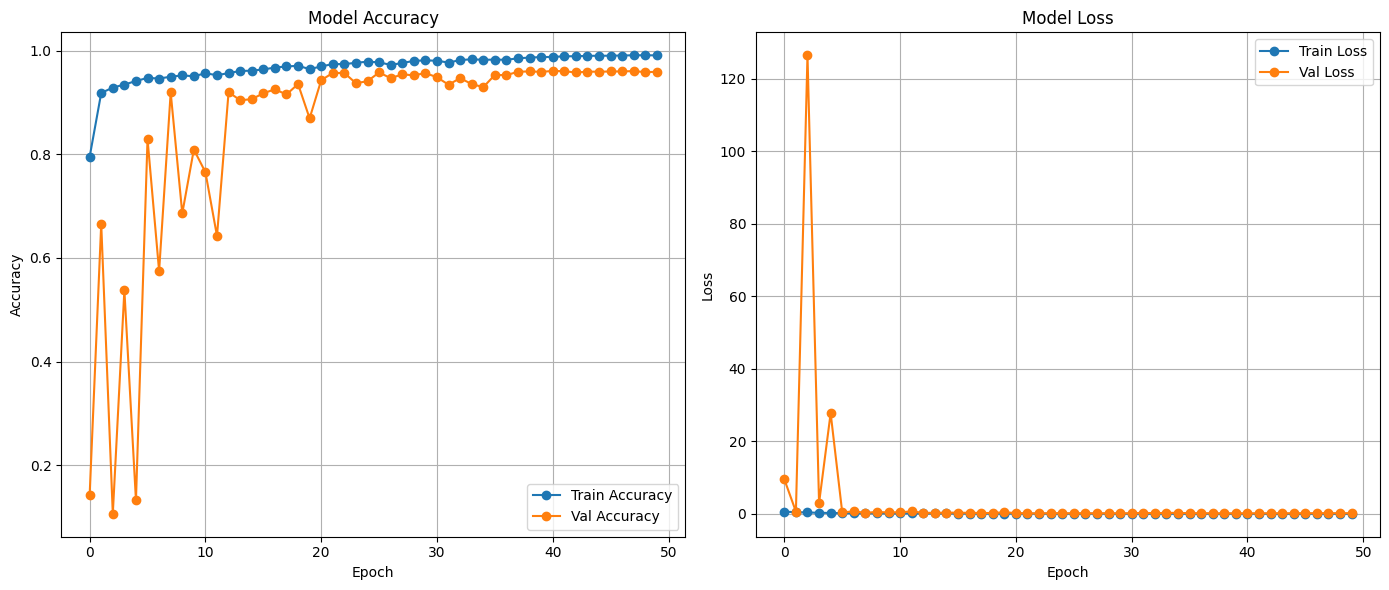

In [ ]:
# ✅ Plot Accuracy and Loss
plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
